In [2]:
pip install datasets


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import dataloader
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sentiment-analysis-for-mental-health' dataset.
Path to dataset files: /kaggle/input/sentiment-analysis-for-mental-health


In [9]:
import os
# List the contents of the directory to find the actual CSV file
dataset_path = "/kaggle/input/sentiment-analysis-for-mental-health"
# print(os.listdir(dataset_path)) # No longer needed after identifying the file

# Load the CSV file into a pandas DataFrame
data = pd.read_csv(os.path.join(dataset_path, 'Combined Data.csv'))
data

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...,...
53038,53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [10]:
data.dropna(inplace=True)
data.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
data

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [11]:
data=data.sample(n=6000, random_state=42).reset_index(drop=True)
data.shape

(6000, 2)

DATA PREPROCESSING

In [12]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords') # Download stopwords corpus

stop_words=set(stopwords.words('english'))

def clean_statement(text):
  text=text.lower()

  text=re.sub(r"[^a-zA-Z\s]",'',text)

  words=text.split()
  words=[word for word in words if word not in stop_words]

  return " ".join(words)

data['statement']=data['statement'].apply(clean_statement)
data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,statement,status
0,im lazy complain ba ihh,Normal
1,think wifi iphone broken quot connect quot act...,Normal
2,good tracking apps ive trying find apps track ...,Bipolar
3,recently looked reddit found place actually qu...,Depression
4,thats favorite thing,Normal
...,...,...
5995,around right photo comfortable place sit beaut...,Depression
5996,tired ready everything life pointless painful ...,Suicidal
5997,friends party man whispers ear likes stare tou...,Stress
5998,add kind info almost thing ive always felt kin...,Depression


In [13]:
data['status'].value_counts()

,count
status,
Normal,1894
Depression,1730
Suicidal,1219
Anxiety,429
Stress,304
Bipolar,293
Personality disorder,131


Need to balance dataset there are three ways
1) oversampling
2) undersampling

In [14]:
from imblearn.over_sampling import RandomOverSampler

ros=RandomOverSampler(sampling_strategy='auto', random_state=42)
x=data.drop('status', axis=1)
y=data['status']

x_resampled, y_resampled=ros.fit_resample(x,y)

data=pd.concat([x_resampled, y_resampled], axis=1)

print(data['status'].value_counts())

status
Normal                  1894
Bipolar                 1894
Depression              1894
Suicidal                1894
Stress                  1894
Personality disorder    1894
Anxiety                 1894
Name: count, dtype: int64


Encoding

In [15]:
label_encoder=LabelEncoder()
data['label']=label_encoder.fit_transform(data['status'])
data


,statement,status,label
0,im lazy complain ba ihh,Normal,3
1,think wifi iphone broken quot connect quot act...,Normal,3
2,good tracking apps ive trying find apps track ...,Bipolar,1
3,recently looked reddit found place actually qu...,Depression,2
4,thats favorite thing,Normal,3
...,...,...,...
13253,cannot afford therapist social anxiety depress...,Suicidal,6
13254,would like die simplei would really like suffe...,Suicidal,6
13255,death day time set affairs might even get bedr...,Suicidal,6
13256,hard seeing others live life would kill know w...,Suicidal,6


In [16]:
train_texts, test_texts, train_labels, test_labels=train_test_split(data['statement'], data['label'], test_size=0.2)

Tokenization ( llm ) ( pre-trained tokenizer BERT)

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, max_length=200)
test_encodings = tokenizer(list(test_texts), padding=True, truncation=True, max_length=200)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [18]:
train_dataset=Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': train_labels.to_list()})
test_dataset=Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'labels': test_labels.to_list()})

Fine Tuning the Model

In [19]:
model=BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", # Corrected from evaluation_strategy to eval_strategy
    save_strategy="epoch",
    learning_rate=2e-5,
    fp16=True,                       # Enables Mixed Precision (Massive speedup on T4)
    per_device_train_batch_size=32,  # Doubled from 16
    per_device_eval_batch_size=32,   # Doubled from 16
    gradient_accumulation_steps=1,   # Ensure this is the only instance of this argument
    dataloader_num_workers=2,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    lr_scheduler_type="linear",
    warmup_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=3
)

trainer=Trainer(model=model, args= training_args,
                train_dataset=train_dataset,
                eval_dataset=test_dataset)
trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged i

Epoch,Training Loss,Validation Loss
1,0.968400,0.946943
2,0.253100,0.413978
3,0.213200,0.313527
4,0.113000,0.250185


Epoch,Training Loss,Validation Loss
1,0.968400,0.946943
2,0.253100,0.413978
3,0.213200,0.313527
4,0.113000,0.250185
5,0.066900,0.257949


TrainOutput(global_step=1660, training_loss=0.5226769265640213, metrics={'train_runtime': 574.9649, 'train_samples_per_second': 92.232, 'train_steps_per_second': 2.887, 'total_flos': 5450549081100000.0, 'train_loss': 0.5226769265640213, 'epoch': 5.0})

                      precision    recall  f1-score   support

             Anxiety       0.97      0.98      0.98       375
             Bipolar       0.99      0.99      0.99       384
          Depression       0.85      0.68      0.75       385
              Normal       0.90      0.93      0.92       367
Personality disorder       0.99      1.00      0.99       354
              Stress       0.95      1.00      0.97       383
            Suicidal       0.76      0.84      0.80       404

            accuracy                           0.91      2652
           macro avg       0.92      0.92      0.91      2652
        weighted avg       0.91      0.91      0.91      2652



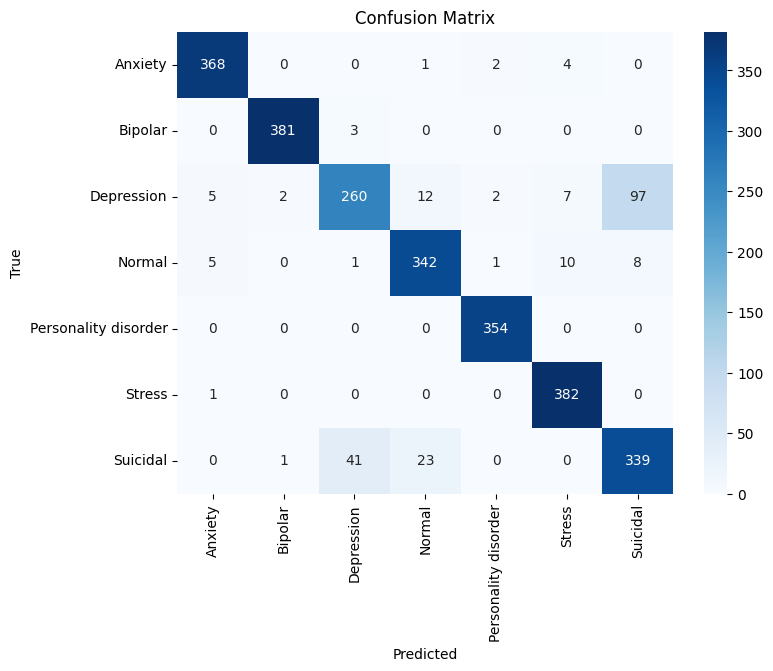

In [26]:
predictions, _, _ = trainer.predict(test_dataset)
predicted_labels=np.argmax(predictions, axis=1)
print(classification_report(test_labels, predicted_labels,target_names=label_encoder.classes_))
cm=confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [28]:
trainer.save_model("/content/drive/MyDrive/saved_mental_bert")

In [29]:
tokenizer.save_pretrained("/content/drive/MyDrive/saved_mental_status_bert")

('/content/drive/MyDrive/saved_mental_status_bert/tokenizer_config.json',
 '/content/drive/MyDrive/saved_mental_status_bert/special_tokens_map.json',
 '/content/drive/MyDrive/saved_mental_status_bert/vocab.txt',
 '/content/drive/MyDrive/saved_mental_status_bert/added_tokens.json')

In [31]:
import pickle

pickle.dump(label_encoder, open('/content/drive/MyDrive/label_encoder.pkl', 'wb'))

from transformers import AutoModelForSequenceClassification, AutoTokenizer

model=AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/saved_mental_bert")
tokenizer=AutoTokenizer.from_pretrained("/content/drive/MyDrive/saved_mental_status_bert")
#
label_encoder=pickle.load(open('/content/drive/MyDrive/label_encoder.pkl', 'rb'))
#

We are now testing the model


In [63]:
import torch
def dectection(text):
  text=clean_statement(text)
  inputs=tokenizer(text, padding=True, truncation=True, max_length=200, return_tensors='pt')
  outputs=model(**inputs)
  logits=outputs.logits
  predicted_labels=torch.argmax(logits, dim=1).item()

  return label_encoder.inverse_transform([predicted_labels])[0]

text="i am not okay i dont feel nice"
dectection(text)

'Normal'